# System Reliablity Assessment for Security of Supply
---
Title: Power system relianbility modelling v1   
Authors: Dr Wei Sun (w.sun@ed.ac.uk), Yifan Wang   
Date: 17-Nov-2022   
<!-- --- -->

In [1]:
import time
st = time.time()

In [2]:
import os
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [3]:
import numpy as np
import pypsa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer
import scotland_network

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [4]:
# write csv files for import
start = '2030-01-01 00:00:00'
end = '2030-12-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [5]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [6]:
year_baseline = 2020
# delet all except links

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [7]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, merge_generators=True)

In [8]:
scotland_network.scotland()
scotland_network.interconnector()

Processed: buses.csv, 
loads.csv, 
generators.csv, 
storage_units.csv, 
generators-marginal_cost.csv, 
generators-p_max_pu.csv, 
loads-p_set.csv, 
links.csv, 
lines.csv, 
links.csv (from lines), 
snapshots.csv


In [9]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data_Scotland')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
Index(['Moyle', 'NorthConnect', 'Neilston-Deeside', 'Strathaven-Harker',
       'Eccles-Stella West'],
      dtype='object')
Index(['Moyle', 'NorthConnect'], dtype='object', name='name')
Index(['Neilston-Deeside', 'Strathaven-Harker', 'Eccles-Stella West'], dtype='object', name='name')
INFO:pypsa.io:Imported network LOPF_data_Scotland has buses, generators, lines, links, loads, storage_units


In [10]:
# network.storage_units = network.storage_units[network.storage_units['carrier']=='Pumped Storage Hydroelectric']

Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [11]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

## System reliablity modelling for security of supply.
The method of  power system reliability modeling is based on Capacity Outage Probability Table
(ref: )

Input Description:
- GENERATOR CAPACITIES is the  capacity of each generator
- GENERATOR OUTAGE is corresponding Forced Outage Rate (EFORd) for each generator (namely, the breakdown rate)

Output Description:
- LOLP: [System Capacity Available, State Probabilities]
- LOLE

## Generation type conversion for breakdown rate

The breakdown rates from National Grid Winter Outlook only include the main generation types. The generation types considered in pypsa-gb are much more that that. Therefore, mapping is needed and provided below.

For wind and other similar weather-dependent generation, they are labeled as 'weather dependent', as their output/contribution will be givenlater using the acctually generation profile time series.

For any type that are reckoned to be excluded at the lolp calculation, they are labeled as 'exlcuded'


In [12]:
bd_conversion_type = [['Coal', 'Nuclear', 'Oil', 'Wind Offshore', 'Wind Onshore', 'Solar Photovoltaics', 'Large Hydro', 'Small Hydro', 'Anaerobic Digestion', 'EfW Incineration', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream', 'Biomass (co-firing)', 'Biomass (dedicated)','Pumped Storage Hydroelectric', 'Battery', 'Compressed Air', 'Liquid Air', 'Interconnector', 'Englandconnector',
                       'CCS Gas', 'CCS Biomass', 'Hydrogen', 'Unmet Load', 'Tidal lagoon', 'Tidal stream', 'Wave power', 'Waste'],
                      ['Coal', 'Nuclear', 'OCGT', 'Weather Dependent', 'Weather Dependent', 'Weather Dependent', 'Hydro', 'Hydro', 'Biomass', 'Biomass', 'Biomass', 'Biomass', 'Excluded', 'Excluded', 'Biomass', 'Biomass','Pumped storage', 'Battery', 'CCGT', 'CCGT', 'Interconnector', 'Englandconnector',
                       'CCGT', 'Biomass', 'CCGT', 'Excluded', 'Excluded', 'Excluded', 'Excluded', 'Biomass']]

In [13]:
bd_conversion_type_csv = pd.DataFrame(bd_conversion_type).T
bd_conversion_type_csv

,0,1
0,Coal,Coal
1,Nuclear,Nuclear
2,Oil,OCGT
3,Wind Offshore,Weather Dependent
4,Wind Onshore,Weather Dependent
5,Solar Photovoltaics,Weather Dependent
6,Large Hydro,Hydro
7,Small Hydro,Hydro
8,Anaerobic Digestion,Biomass
9,EfW Incineration,Biomass


## Breakdown rate table

This is based on NG winter outlook. It would be subject to changes based on the users' knowledges or more updated information.  
Reference: https://www.nationalgrideso.com/document/268346/download page 12     
Battery reference: https://www.emrdeliverybody.com/Lists/Latest%20News/Attachments/150/Duration%20Limited%20Storage%20De-Rating%20Factor%20Assessment%20-%20Final.pdf page 4    

In [14]:
breakdowwn_rate = {
    'Coal': 0.1,
    'CCGT': 0.06,
    'Nuclear': 0.1,
    'OCGT': 0.07,
    'Biomass': 0.06,
    'Hydro': 0.08,
    'Wind': 0.16,
    'Pumped storage': 0.03, # arbitrary, need to update
    'Interconnector': 0.2,
    'Englandconnector': 0.2,
    'Weather Dependent': 0,
    'Excluded': 1
}
br_csv = pd.DataFrame.from_dict(breakdowwn_rate,orient='index',columns=['Breakdown Rate'])
br_csv = br_csv.reset_index().rename(columns = {'index':'Type'})
br_csv

,Type,Breakdown Rate
0,Coal,0.10
1,CCGT,0.06
2,Nuclear,0.10
3,OCGT,0.07
4,Biomass,0.06
5,Hydro,0.08
6,Wind,0.16
7,Pumped storage,0.03
8,Interconnector,0.20
9,Englandconnector,0.20


In [15]:
breakdowwn_rate_battery = {
    '0.5h': 0.1789,
    '1.0h': 0.3644,
    '1.5h': 0.5228,
    '2.0h': 0.6479,
    '2.5h': 0.7547,
    '3.0h': 0.8203,
    '3.5h':0.8575,
    '4.0h': 0.9611 # 4+h
}
brb_csv = pd.DataFrame.from_dict(breakdowwn_rate_battery,orient='index',columns=['Breakdown Rate'])
brb_csv = brb_csv.reset_index().rename(columns = {'index':'Duration'})
brb_csv

,Duration,Breakdown Rate
0,0.5h,0.1789
1,1.0h,0.3644
2,1.5h,0.5228
3,2.0h,0.6479
4,2.5h,0.7547
5,3.0h,0.8203
6,3.5h,0.8575
7,4.0h,0.9611


## De-rate table 

Reference: https://www.nationalgrideso.com/document/268356/download

In [16]:
de_conversion_type = [['Coal', 'Nuclear', 'Oil', 'Wind Offshore', 'Wind Onshore', 'Solar Photovoltaics', 'Large Hydro', 'Small Hydro', 'Anaerobic Digestion', 'EfW Incineration', 'Landfill Gas', 'Sewage Sludge Digestion', 'Shoreline Wave', 'Tidal Barrage and Tidal Stream', 'Biomass (co-firing)', 'Biomass (dedicated)','Pumped Storage Hydroelectric', 'Battery', 'Compressed Air', 'Liquid Air', 'Interconnector', 'Englandconnector', 
                       'CCS Gas', 'CCS Biomass', 'Hydrogen', 'Unmet Load', 'Tidal lagoon', 'Tidal stream', 'Wave power','Waste'],
                      ['Coal', 'Nuclear', 'OCGT', 'Wind', 'Wind', 'Solar', 'Hydro', 'Hydro', 'Waste', 'Waste', 'Waste', 'Waste', 'Marine', 'Marine', 'Biomass', 'Biomass','Pumped storage', 'Battery storage', 'OCGT', 'OCGT', 'Interconnector', 'Interconnector',
                       'CCGT', 'Biomass', 'CCGT', 'Excluded', 'Marine', 'Marine', 'Marine','Waste']]

In [17]:
de_conversion_type_csv = pd.DataFrame(de_conversion_type).T
#bd_conversion_type_csv.to_csv('../data/de_conversion_type.csv',index=False)

In [18]:
de_conversion_type_csv

,0,1
0,Coal,Coal
1,Nuclear,Nuclear
2,Oil,OCGT
3,Wind Offshore,Wind
4,Wind Onshore,Wind
5,Solar Photovoltaics,Solar
6,Large Hydro,Hydro
7,Small Hydro,Hydro
8,Anaerobic Digestion,Waste
9,EfW Incineration,Waste


In [19]:
de_rate = {
    'Biomass': 0.88,
    'Waste': 0.745, # average for various
    'Coal': 0.76,
    'CCGT': 0.913, # CHP/cogeneration 
    'OCGT': 0.952, # gas & diesel reciprocating engines
    'Nuclear': 0.744,
    'Battery storage': 0.597,
    'Pumped storage': 0.952,
    'Hydro': 0.911,
    'Solar': 0.022,
    'Marine': 0.22,
    'Wind': 0.174, #offshore & onshore
    'DSR': 0.715,
    'Interconnector': 0.099,
    'Excluded': 0
}
de_csv = pd.DataFrame.from_dict(de_rate,orient='index',columns=['De-Rate'])
de_csv = de_csv.reset_index().rename(columns = {'index':'Type'})
de_csv

,Type,De-Rate
0,Biomass,0.880
1,Waste,0.745
2,Coal,0.760
3,CCGT,0.913
4,OCGT,0.952
5,Nuclear,0.744
6,Battery storage,0.597
7,Pumped storage,0.952
8,Hydro,0.911
9,Solar,0.022


In [20]:
# this just provide a option to read breakdown rate table from a .csv file, 
# rather than hard-coded in the notebook
import os
if not os.path.exists('../data/LOLE'):
    os.makedirs('../data/LOLE')
bd_conversion_type_csv.to_csv('../data/LOLE/bd_conversion_type.csv',index=False)
br_csv.to_csv('../data/LOLE/breakdown_rate.csv',index=False)
brb_csv.to_csv('../data/LOLE/breakdowwn_rate_battery.csv',index=False)
de_conversion_type_csv.to_csv('../data/LOLE/de_conversion_type.csv',index=False)
de_csv.to_csv('../data/LOLE/de_rate.csv',index=False)

In [21]:
system_reserve_requirment = 1200 #MW, from NG winter outlook 2022

## Calculate system margin, LOLP and LOLE

In [22]:
def get_rate(row, name_list, carrier, conversion_dict, power_stations, breakdown_rate, breakdowwn_rate_battery=None, storage_units= None):
    for i in range(len(carrier)):
        # if row[i] != [0]: only running stations
        name = name_list[i]
        fuel_type = convert_type(name, carrier, conversion_dict, power_stations)
        if fuel_type != 'Battery':
            rate = breakdown_rate[fuel_type]
        else:
            max_hours = storage_units[storage_units.index == name]['max_hours'].tolist()[0]
            max_hours = np.rint(max_hours * 2) / 2
            max_hours = min(max_hours, 4)
            rate = breakdowwn_rate_battery[str(max_hours) + 'h']        
        row[i] = rate
    return row

In [23]:
def convert_type(name, carrier, conversion_dict, power_stations):
    type0 = carrier[name]
    try:
        type1 = conversion_dict[type0]
    except:
        if type0 == 'Natural Gas':
            type1 = power_stations[power_stations['Station Name']==name]['Technology'].tolist()[0]
        else:
            type1 = 'Excluded'
#             if 'new_type_list' not in globals():
#                 global new_type_list
#                 new_type_list = list()
#             if type0 not in new_type_list:
#                 new_type_list.append(type0)
            print('Do not have break downrate for type ' + type0)
    return type1

In [24]:
breakdowwn_rate_battery = pd.read_csv('../data/LOLE/breakdowwn_rate_battery.csv',index_col=0)
breakdowwn_rate_battery = breakdowwn_rate_battery.to_dict()['Breakdown Rate']
breakdowwn_rate_battery

{'0.5h': 0.1789,
 '1.0h': 0.3644,
 '1.5h': 0.5228,
 '2.0h': 0.6479,
 '2.5h': 0.7547,
 '3.0h': 0.8203,
 '3.5h': 0.8575,
 '4.0h': 0.9611}

In [25]:
breakdown_rate = pd.read_csv('../data/LOLE/breakdown_rate.csv',index_col=0)

In [26]:
breakdowwn_rate_battery = pd.read_csv('../data/LOLE/breakdowwn_rate_battery.csv',index_col=0)

In [27]:
breakdowwn_rate_battery

,Breakdown Rate
Duration,
0.5h,0.1789
1.0h,0.3644
1.5h,0.5228
2.0h,0.6479
2.5h,0.7547
3.0h,0.8203
3.5h,0.8575
4.0h,0.9611


In [28]:
breakdowwn_rate_battery['Breakdown Rate'] = 1-(1-breakdowwn_rate_battery['Breakdown Rate'])*0

In [29]:
breakdowwn_rate_battery

,Breakdown Rate
Duration,
0.5h,1.0
1.0h,1.0
1.5h,1.0
2.0h,1.0
2.5h,1.0
3.0h,1.0
3.5h,1.0
4.0h,1.0


In [30]:
#  calculate lolp without running opf/uc
def LOLP(network, year, year_baseline=None, failures_type=None, failures_rate=None):
    
    # rate
    if year > 2020:
        year = year_baseline
    file = '../data/power stations/power_stations_locations_' + str(year) + '.csv'
    power_stations = pd.read_csv(file, encoding='unicode_escape')
    
    bd_conversion_csv = pd.read_csv('../data/LOLE/bd_conversion_type.csv',index_col=0)
    bd_conversion_dict = bd_conversion_csv.to_dict()['1']
    
    
    breakdown_rate = pd.read_csv('../data/LOLE/breakdown_rate.csv',index_col=0)
    
    breakdowwn_rate_battery = pd.read_csv('../data/LOLE/breakdowwn_rate_battery.csv',index_col=0)
    
    
    if (failures_type is not None) and (failures_type is not None):
        failures_type = [failures_type]
        failures_rate = [failures_rate]
        if len(failures_type) != len(failures_rate):
            failures_rate = failures_rate * len(failures_type)
        for _ in range(len(failures_type)):
            generator_type = failures_type[_]
            if generator_type != 'Battery':
                breakdown_rate.loc[generator_type] = 1 - (1 - breakdown_rate.loc[generator_type]) * failures_rate[_]
            else:
                breakdowwn_rate_battery['Breakdown Rate'] = 1 - (1-breakdowwn_rate_battery['Breakdown Rate']) * failures_rate[_]
            
    breakdown_rate = breakdown_rate.to_dict()['Breakdown Rate']
    breakdowwn_rate_battery = breakdowwn_rate_battery.to_dict()['Breakdown Rate']
    
    generators_name_list = network.generators.index.tolist() ##
    
    #  generator units' breakdown rate time-series dataframe: generators_rate
    generators_rate_col = generators_name_list
    generators_rate_index = network.snapshots.copy()
    generators_rate = pd.DataFrame(columns=generators_rate_col, index=generators_rate_index) 
    generators_rate.apply(lambda r: get_rate(r, generators_name_list, network.generators.carrier, bd_conversion_dict, power_stations, breakdown_rate), axis = 1)
    
    # storage units' breakdown rate time-series dataframe: storage_rate
    storage_units_name_list = network.storage_units.index.tolist() 
    storage_units_rate_col = storage_units_name_list
    storage_units_rate_index = network.snapshots.copy()
    storage_units_rate = pd.DataFrame(columns=storage_units_rate_col, index=storage_units_rate_index) ##
    storage_units_rate.apply(lambda r: get_rate(r, storage_units_name_list, network.storage_units.carrier, bd_conversion_dict, power_stations, breakdown_rate, breakdowwn_rate_battery, network.storage_units), axis = 1)
    
    # all units' breakdown rate
    pd_rate = pd.concat([generators_rate, storage_units_rate], axis=1)
    # pd_rate2 = pd_rate.copy()
    
    # caculate time series of weather dependent generators' outputs from input data 

    pd_stations = pd_rate.copy()
    pd_stations_w = pd_stations[network.generators.index.tolist()][(pd_rate == 0)].dropna(axis=1,how='all').fillna(0)
    pd_stations[network.generators.p_nom.index] = network.generators.p_nom.values
    pd_stations[network.storage_units.p_nom.index] = network.storage_units.p_nom.values
    pd_stations[pd_stations_w.columns] = network.generators_t.p_max_pu[pd_stations_w.columns] * network.generators.p_nom[pd_stations_w.columns]

    pd_stations_all = pd_stations.copy()
    
    pd_stations_w = pd_stations[pd_stations_w.columns.tolist()]#[(pd_rate == 0)].dropna(axis=1,how='all').fillna(0)
    ## Shoreline Wave, Tidal Barrage and Tidal Stream

    pd_stations = pd_stations[(pd_rate < 1) & (pd_rate > 0)].dropna(axis=1,how='all').fillna(0)
    
    # Note: now, the time series of breakdown rate ONLY include non weather dependent units (i.e. convertional units)
    pd_rate = pd_rate[(pd_rate < 1) & (pd_rate > 0)].dropna(axis=1,how='all').fillna(0)
    
    # net_demand
    # calculate net_demand from input data (value is empty)
    # net_demand = total demand - renewable (Weather Dependent) output.
    net_demand = network.loads_t.p_set.sum(axis=1) - pd_stations_w.sum(axis=1)
    
    
    # non renewable generator units' installed capacity
    installed_capacity = pd.concat([network.generators.p_nom, network.storage_units.p_nom], axis=0)[pd_stations.columns].to_numpy()
    
    return installed_capacity, pd_rate.to_numpy()[0], net_demand, pd_stations_all, pd_stations_w
    

In [31]:
def Margin(network, pd_stations,year, system_reserve_requirment, year_baseline=None):

    # rate
    if year > 2020:
        year = year_baseline
    file = '../data/power stations/power_stations_locations_' + str(year) + '.csv'
    power_stations = pd.read_csv(file, encoding='unicode_escape')
    
    de_conversion_csv = pd.read_csv('../data/LOLE/de_conversion_type.csv',index_col=0)
    de_conversion_dict = de_conversion_csv.to_dict()['1']
    
    de_rate = pd.read_csv('../data/LOLE/de_rate.csv',index_col=0)
    de_rate = de_rate.to_dict()['De-Rate']
    
    generators_name_list = network.generators.index.tolist() ##
    
    #  generator units' breakdown rate time-series dataframe: generators_rate
    generators_rate_col = generators_name_list
    generators_rate_index = network.snapshots.copy()
    generators_rate = pd.DataFrame(columns=generators_rate_col, index=generators_rate_index) 
    generators_rate.apply(lambda r: get_rate(r, generators_name_list, network.generators.carrier, de_conversion_dict, power_stations, de_rate), axis = 1)
    
    # storage units' breakdown rate time-series dataframe: storage_rate
    storage_units_name_list = network.storage_units.index.tolist() 
    storage_units_rate_col = storage_units_name_list
    storage_units_rate_index = network.snapshots.copy()
    storage_units_rate = pd.DataFrame(columns=storage_units_rate_col, index=storage_units_rate_index) ##
    storage_units_rate.apply(lambda r: get_rate(r, storage_units_name_list, network.storage_units.carrier, de_conversion_dict, power_stations, de_rate), axis = 1)
    
    # all units' breakdown rate
    pd_rate = pd.concat([generators_rate, storage_units_rate], axis=1) 
    
    # caculate time series of weather dependent generators' outputs from input data 

    pd_installed_capacity = pd.concat([network.generators.p_nom, network.storage_units.p_nom], axis=0)
    de_rated_capacity = (pd_installed_capacity * pd_rate).sum(axis =1)[0]
    margin = de_rated_capacity - network.loads_t.p_set.sum(axis=1) - system_reserve_requirment # reserve
    
    return de_rated_capacity, margin

In [32]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline)

In [33]:
de_rated_capacity, margin = Margin(network, pd_stations_all, year, system_reserve_requirment, year_baseline=year_baseline)

In [34]:
de_rated_capacity

10554.199758789622

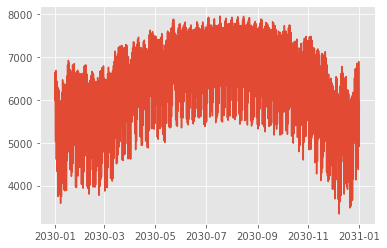

In [35]:
plt.plot(margin)

In [36]:
margin.describe()

count    8760.000000
mean     6247.079059
std       844.042734
min      3337.023310
25%      5679.960460
50%      6354.239006
75%      6790.433698
max      7954.381922
dtype: float64

In [37]:
network.loads_t.p_set.sum(axis=1).describe()

count    8760.000000
mean     3107.120700
std       844.042734
min      1399.817836
25%      2563.766061
50%      2999.960753
75%      3674.239299
max      6017.176448
dtype: float64

In [38]:
pd.Series(net_demand).describe()

count     8760.000000
mean     -6588.761086
std       6817.163013
min     -22307.048247
25%     -11937.703028
50%      -5212.661513
75%       -518.989053
max       5229.145241
dtype: float64

Small generator units can be exlcuded from lolp calculation if necessary (i.e. assuming they are not contributing to reliability analysis)

In [39]:
def split_generators(installed_capacity, breakdwon_rate, num = None, value = 0, Round = False):
    if num == None:
        num = installed_capacity.shape[0]
    sorted_capacity = np.sort(installed_capacity[installed_capacity >= value])
    boundary = sorted_capacity[max(sorted_capacity.shape[0] - num, 0)]
    large_capacity = np.copy(installed_capacity[installed_capacity >= boundary])
    large_breakdwon_rate = np.copy(breakdwon_rate[installed_capacity >= boundary])
    expect_small_capacity = sum(installed_capacity[installed_capacity < boundary] * (1 - breakdwon_rate[installed_capacity < boundary]))
    if Round:
        large_capacity = np.rint(large_capacity)
    print('Number of laege generators: ' + str(large_capacity.shape[0]))
    print('Boundary: ' + str(boundary))
    
    return large_capacity, large_breakdwon_rate, expect_small_capacity

In [40]:
# exclude any generator small than 50 WM (criteria would be subject to change)
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 0, Round=True)

Number of laege generators: 68
Boundary: 0.1137931034482758


## Calculating PDF and CDF of power supply based on breakdown rate

In [41]:
def dict_add(A,B):
    for key,value in B.items():
        try:
            A[key] += value
        except:
            A[key] = value
    return A

In [42]:
def probability_function(capacity, breakdwon_rate):
    pdf = dict()
    pdf[0] = 1

    for i in range(large_capacity.shape[0]):
        prob_down = dict()
        prob_up = dict()
    
        for key,value in pdf.items():
            avail_value = np.float64(key)+large_capacity[i]
            try:
                prob_up[avail_value] += value * (1-large_breakdwon_rate[i])
            except:
                prob_up[avail_value] = value * (1-large_breakdwon_rate[i])
            try:
                prob_down[key] += value * large_breakdwon_rate[i]
            except:
                prob_down[key] = value * large_breakdwon_rate[i]
        pdf = dict_add(prob_up,prob_down)
    pdf = dict(sorted(pdf.items(),key=lambda d:d[0]))
    xx = sorted(pdf)
    yy = np.zeros(len(xx))
    cdf = np.zeros(len(xx))
    cdf_i = 0
    for i in range(len(pdf)):
        key = xx[i]
        yy[i] = pdf[key]
        cdf_i += yy[i]
        cdf[i] = cdf_i
    return xx, yy, pdf, cdf

In [43]:
xx, yy, pdf, cdf = probability_function(large_capacity, large_breakdwon_rate)

## plot and prettify the PDF of system generation capacity available

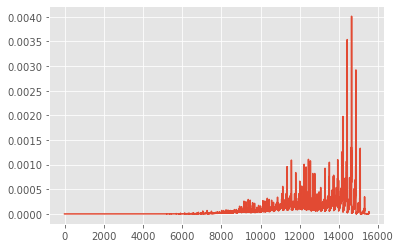

In [44]:
plt.plot(xx,yy)

In [45]:
np.mean(net_demand)

-6588.761086302504

(9315.6, 17078.600000000002)

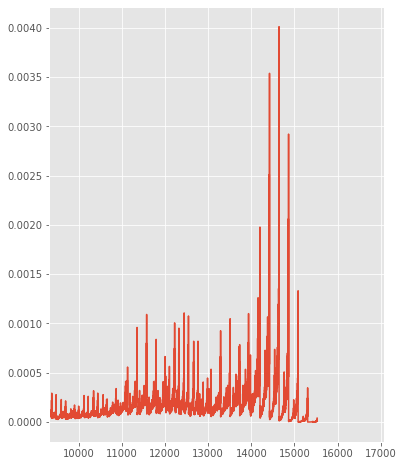

In [46]:
plt.figure(figsize=(6,8))
plt.plot(xx,yy)
plt.xlim(max(xx)*.6,max(xx)*1.1)

In [47]:
int_x = [round(x/100)*100 for x in xx]

(9315.6, 17078.600000000002)

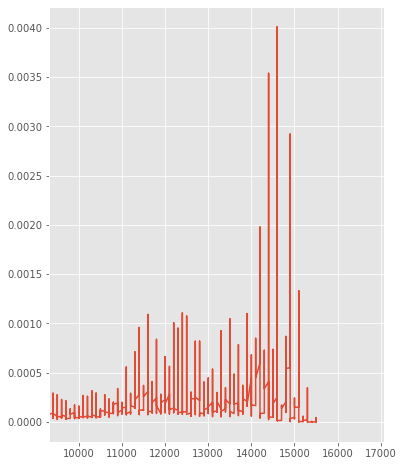

In [48]:
plt.figure(figsize=(6,8))
plt.plot(int_x,yy)
plt.xlim(max(xx)*.6,max(xx)*1.1)

## plot CDF of ystem generation capacity available

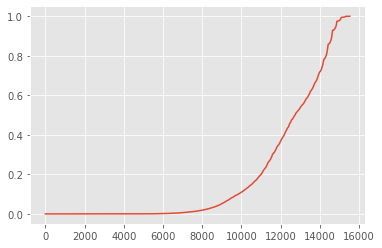

In [49]:
plt.plot(xx,cdf)

## calculating the LOLP at each time step

In [50]:
net_demand = network.loads_t.p_set.sum(axis=1) - pd_stations_w.sum(axis=1)

In [51]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [52]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())
sum(lolp)

0.026650622694260318

In [53]:
np.array(lolp)[np.array(lolp)>0]

array([1.05496708e-15, 4.64573445e-16, 6.43511540e-17, ...,
       1.26167050e-10, 3.02048862e-13, 1.03889814e-56])

In [54]:
sum(np.array(lolp)==0)

6163

In [55]:
# lolp_min = np.where(lolp == min(lolp))
lolp_min = np.where(lolp == min(np.array(lolp)[np.array(lolp)>0]))
network.snapshots[lolp_min[0][0]]

Timestamp('2030-06-04 14:00:00')

In [56]:
lolp_max = np.where(lolp == max(lolp))
network.snapshots[lolp_max[0][0]]

Timestamp('2030-12-06 19:00:00')

## calculating the LOLE over the whole period

In [57]:
lole = sum(lolp)
print(f'the loss load expectation (LOLE) for the considered period are {lole} hours; the current UK regulation for LOLE is below 3 hours per year')

the loss load expectation (LOLE) for the considered period are 0.026650622694260318 hours; the current UK regulation for LOLE is below 3 hours per year


## plot

In [58]:
plot_data = pd.DataFrame()
plot_data.index = network.snapshots
plot_data['demand'] = net_demand
plot_data['lolp'] = lolp

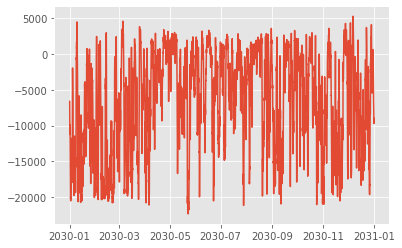

In [59]:
plt.plot(plot_data['demand'])

In [60]:
lolp_month = list()
for m in range(1,13):
    month_data = plot_data[plot_data.index.month == m]
    lolp_month.append(month_data['lolp'].tolist())

{'whiskers': [<matplotlib.lines.Line2D at 0x23c4c81d1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x23c4c81d790>,
 'boxes': [<matplotlib.lines.Line2D at 0x23c4c80fee0>,
 'medians': [<matplotlib.lines.Line2D at 0x23c4c81dd30>,
 'fliers': [<matplotlib.lines.Line2D at 0x23c4c82a040>,
 'means': []}

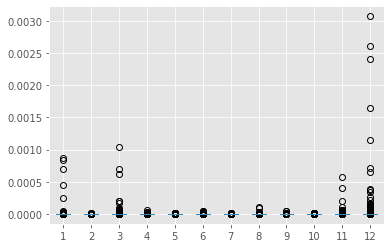

In [61]:
plt.boxplot(lolp_month)

In [62]:
lolp_hour = list()
for h in range(24):
    hour_data = plot_data[plot_data.index.hour == h]
    lolp_hour.append(hour_data['lolp'].mean())

([<matplotlib.axis.XTick at 0x23c4d036d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

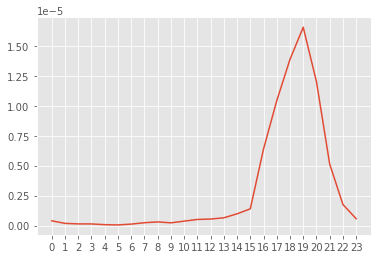

In [63]:
plt.plot(lolp_hour)
plt.xticks(range(24))

## Scenario

In [64]:
peak_demand = network.loads_t.p_set.sum(axis=1).max()
peak_demand

6017.176448405839

In [65]:
pd_peakload_period = pd.DataFrame(pd_stations_w.sum(axis=1),columns=['weather dependent capacity'])
pd_peakload_period

,weather dependent capacity
snapshot,
2030-01-01 00:00:00,9995.148900
2030-01-01 01:00:00,10500.853600
2030-01-01 02:00:00,11085.999815
2030-01-01 03:00:00,11483.737743
2030-01-01 04:00:00,12201.357324
...,...
2030-12-31 19:00:00,13626.673242
2030-12-31 20:00:00,13660.690919
2030-12-31 21:00:00,13656.413905


In [66]:
pd_peakload_period = pd_peakload_period[((pd_peakload_period.index.month<4)|(pd_peakload_period.index.month>10)) &
              (pd_peakload_period.index.weekday<6) &
              (pd_peakload_period.index.hour>6) & (pd_peakload_period.index.hour<20)]
pd_peakload_period

,weather dependent capacity
snapshot,
2030-01-01 07:00:00,14026.920500
2030-01-01 08:00:00,14074.807589
2030-01-01 09:00:00,14061.014362
2030-01-01 10:00:00,13180.169828
2030-01-01 11:00:00,13605.790952
...,...
2030-12-31 15:00:00,11590.322264
2030-12-31 16:00:00,11779.623416
2030-12-31 17:00:00,12597.969138


In [67]:
wdc = pd_peakload_period['weather dependent capacity'].to_numpy()

In [68]:
wdc.shape

(1677,)

In [69]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [70]:
lolp_p

0.00017370119783138204

### 2.1 Largest offshore wind farm failure 

In [71]:
largest_windfarm = network.generators_t.p_max_pu[network.generators[network.generators.carrier.isin(['Wind Onshore', 'Wind Offshore'])].p_nom.idxmax()] * network.generators[network.generators.carrier.isin(['Wind Onshore', 'Wind Offshore'])].p_nom.max()

In [72]:
pd_peakload_period['largest windfarm supply'] = largest_windfarm[largest_windfarm.index.isin(pd_peakload_period.index)]

In [73]:
lws = pd_peakload_period['largest windfarm supply'].to_numpy()

In [74]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] + largest_windfarm[i] - expect_small_capacity + system_reserve_requirment].sum())

In [75]:
sum(lolp)

0.02955658735885177

In [76]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]+lws[i]-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [77]:
lolp_p

0.00020118514421436646

### 2.2 Long period of low RES power scenario

In [78]:
net_demand = network.loads_t.p_set.sum(axis=1) - pd_stations_w.sum(axis=1) * 0.8

In [79]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [80]:
sum(lolp)

0.03620477752667691

In [81]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]*0.8-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [82]:
lolp_p

0.0002368895297554625

### 1 Gas supply issues 

In [83]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline, failures_type=['CCGT','OCGT'], failures_rate=0.)

In [84]:
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 0, Round=True)
xx, yy, pdf, cdf = probability_function(large_capacity, large_breakdwon_rate)

Number of laege generators: 41
Boundary: 1.08


In [85]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [86]:
sum(lolp)

0.5646741145670412

In [87]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [88]:
lolp_p

0.001462078068998871

### 3.1 Storage failures

In [89]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline, failures_type='Battery', failures_rate=0.)

In [90]:
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 0, Round=True)
xx, yy, pdf, cdf = probability_function(large_capacity, large_breakdwon_rate)

Number of laege generators: 60
Boundary: 0.1137931034482758


In [91]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [92]:
sum(lolp)

0.11691805568896269

In [93]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [94]:
lolp_p

0.0005128731366773246

### 3.2 Interconnector failure

In [95]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline, failures_type='Interconnector', failures_rate=0.)

In [96]:
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 0, Round=True)
xx, yy, pdf, cdf = probability_function(large_capacity, large_breakdwon_rate)

Number of laege generators: 66
Boundary: 0.1137931034482758


In [97]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [98]:
sum(lolp)

0.1904626071399894

In [99]:
lolp_p = 0
for i in range(wdc.shape[0]):
    lolp_p += yy[xx<peak_demand-wdc[i]-expect_small_capacity+system_reserve_requirment].sum()/wdc.shape[0]

In [100]:
lolp_p

0.000732378393688788

## self-sufficient Scotland

In [101]:
installed_capacity, breakdwon_rate, net_demand, pd_stations_all, pd_stations_w = LOLP(network, year, year_baseline=year_baseline, failures_type=['Interconnector','Englandconnector'], failures_rate=0.)

In [102]:
large_capacity, large_breakdwon_rate, expect_small_capacity = split_generators(installed_capacity, breakdwon_rate, value = 0, Round=True)
xx, yy, pdf, cdf = probability_function(large_capacity, large_breakdwon_rate)

Number of laege generators: 63
Boundary: 0.1137931034482758


In [103]:
lolp = list()
for i in range(len(net_demand)):
    lolp.append(yy[xx<net_demand[i] - expect_small_capacity + system_reserve_requirment].sum())

In [104]:
sum(lolp)

22.597503733123318

In [105]:
# test lole changes with adding increased firm capacity 
for i_ in range(1,10):
    lolp = list()
    for i in range(len(net_demand)):
        lolp.append(yy[xx<net_demand[i]-expect_small_capacity+system_reserve_requirment-i_*200].sum())
    lole = sum(lolp)
    print(f'for {i_*200}MW increased firm capacity, lole is {lole}')

for 200MW increased firm capacity, lole is 15.91464930090127
for 400MW increased firm capacity, lole is 11.071036465862067
for 600MW increased firm capacity, lole is 7.679536352103571
for 800MW increased firm capacity, lole is 5.146483166539717
for 1000MW increased firm capacity, lole is 3.3142594527351403
for 1200MW increased firm capacity, lole is 2.03502118100283
for 1400MW increased firm capacity, lole is 1.2346162413906303
for 1600MW increased firm capacity, lole is 0.744233956679044
for 1800MW increased firm capacity, lole is 0.4322243630761733


In [106]:
print(time.time()-st)

181.2648196220398
